In [1]:
import sys
import sklearn
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## 퍼셉트론

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [3]:
y_pred

array([1])

## 활성화 함수

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z- eps)) / (2 * eps)

그림 저장: activation_functions_plot


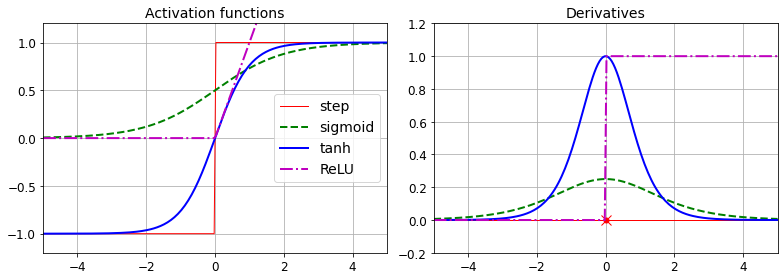

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label='step')
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label="tanh")
plt.plot(z, relu(z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z),  "r-", linewidth=1, label="step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', linewidth=2, label="sigmoid")
plt.plot(z, derivative(np.tanh, z), 'b-', linewidth=2, label="tanh")
plt.plot(z, derivative(relu, z), 'm-.', linewidth=2, label="ReLU")
plt.grid(True)

plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## 이미지 분류기 만들기

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [8]:
X_train_full.shape # 28 x 28 픽셀 

(60000, 28, 28)

In [9]:
X_train_full.dtype 

dtype('uint8')

In [10]:
# 각 픽셀의 강도는 바이트 (0 ~ 255)로 표현
# 픽셀 강도를 255로 나누어 0~1 범위의 실수로 바꿈
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

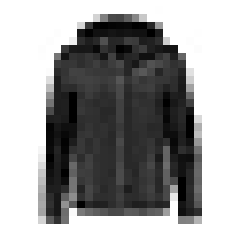

In [11]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

In [12]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

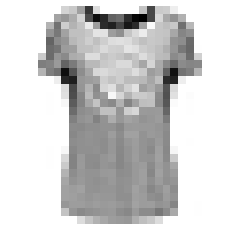

In [13]:
plt.imshow(X_train[1], cmap='binary')
plt.axis('off')
plt.show()

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [15]:
class_names[y_train[0]]

'Coat'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
그림 저장: fashion_mnist_plot


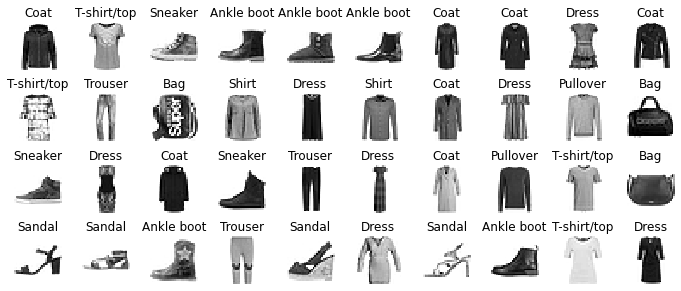

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        print(index)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap='binary', interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [17]:
# 두개의 은닉층으로 이루어진 분류용 다층 퍼셉트론
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) 
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# 같음
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


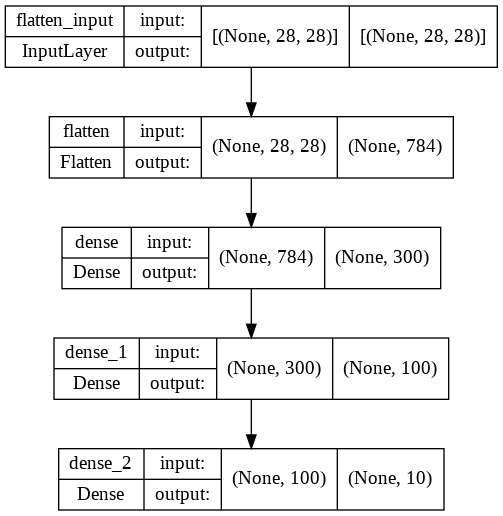

In [19]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [20]:
model.layers

In [21]:
hidden1 = model.layers[1]

In [22]:
hidden1.name

'dense'

In [23]:
model.get_layer('dense') is hidden1

True

In [24]:
weights, biases = hidden1.get_weights()

In [25]:
# 모델 만들고 나서 compile() 메서드 호출하여 손실 함수와 옵티마이저 지정
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [26]:
# 모델 훈련과 평가
history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_valid, y_valid)) # 검증 세트는 선택사항


Epoch 1/30
1719/1719 [==============================] - 12s 4ms/step - loss: 0.7267 - accuracy: 0.7601 - val_loss: 0.5122 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4910 - accuracy: 0.8292 - val_loss: 0.4721 - val_accuracy: 0.8334
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4461 - accuracy: 0.8436 - val_loss: 0.4263 - val_accuracy: 0.8516
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4174 - accuracy: 0.8533 - val_loss: 0.4026 - val_accuracy: 0.8638
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3974 - accuracy: 0.8608 - val_loss: 0.3751 - val_accuracy: 0.8730
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3799 - accuracy: 0.8656 - val_loss: 0.3912 - val_accuracy: 0.8620
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3667 - accuracy: 0.8696 - val_loss: 0.3733 - val_accuracy

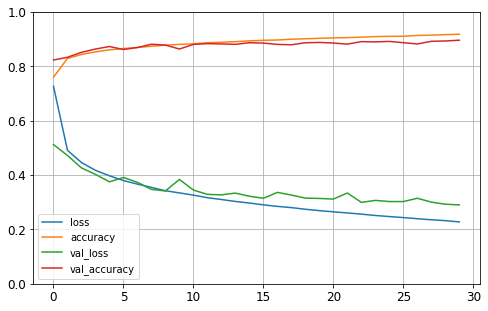

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
# 훈련 곡선을 볼 때 왼쪽으로 에포크의 절반만큼 이동해서 생각해야한다
# 검증 손실은 에포크가 끝난 후에 계산되고 훈련 소실은 에포크 진행되는 동안 계산되기 때문

In [28]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3304 - accuracy: 0.8828


[0.33035704493522644, 0.8827999830245972]

In [29]:
# 모델을 사용해 예측 만들기
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [31]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

그림 저장: fashion_mnist_images_plot


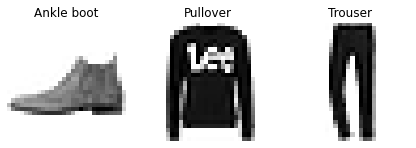

In [32]:
plt.figure(figsize=(7.2, 2.4))

for index, image in enumerate(X_new):
  plt.subplot(1, 3, index + 1)
  plt.imshow(image, cmap="binary", interpolation="nearest")
  plt.axis("off")
  plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

In [33]:
## 회귀 MLP

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test= train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [34]:
# 출력층 활성화 함수가 없는 하나의 뉴런을 가지고 손실 함수로 평균제곱오차를 사용
# 과대적합을 막는 용도로 뉴런 수가 적은 은닉층 하나만 사용

model = keras.models.Sequential([
                                 keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
                                 keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 4s 7ms/step - loss: 1.4728 - val_loss: 0.5935
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4971 - val_loss: 0.4923
Epoch 3/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4468 - val_loss: 0.4573
Epoch 4/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4240 - val_loss: 0.4392
Epoch 5/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4083 - val_loss: 0.4331
Epoch 6/20
363/363 [==============================] - 2s 7ms/step - loss: 0.3995 - val_loss: 0.4241
Epoch 7/20
363/363 [==============================] - 2s 6ms/step - loss: 0.3916 - val_loss: 0.4197
Epoch 8/20
363/363 [==============================] - 2s 6ms/step - loss: 0.3898 - val_loss: 0.4103
Epoch 9/20
363/363 [==============================] - 2s 6ms/step - loss: 0.3813 - val_loss: 0.4431
Epoch 10/20
363/363 [==============================] - 2s 7ms/step - loss: 0.3779 - val_loss: 0.4038

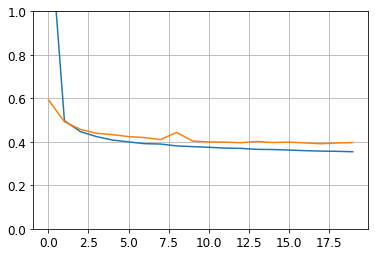

In [36]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [38]:
## 함수형 API
# 매우 복잡한 구조를 가지는 신경망
# 여러 개의 입력이 있거나 여러개의 출력이 있음
# 와이드&딥 신경망 : 입력의 전체 또는 일부를 출력층에 바로 연결

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 30)           270         ['input_2[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 30)           930         ['dense_6[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_2[0][0]',                
                                                                  'dense_7[0][0]']            

In [41]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 3s 8ms/step - loss: 1.6083 - val_loss: 0.7798
Epoch 2/20
363/363 [==============================] - 2s 7ms/step - loss: 0.7042 - val_loss: 0.6829
Epoch 3/20
363/363 [==============================] - 3s 7ms/step - loss: 0.6460 - val_loss: 0.6416
Epoch 4/20
363/363 [==============================] - 3s 7ms/step - loss: 0.6102 - val_loss: 0.6118
Epoch 5/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5845 - val_loss: 0.5889
Epoch 6/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5641 - val_loss: 0.5739
Epoch 7/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5472 - val_loss: 0.5547
Epoch 8/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5339 - val_loss: 0.5423
Epoch 9/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5223 - val_loss: 0.5324
Epoch 10/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5126 - val_loss: 0.5245

In [44]:
# 일부 특성은 짧은 경로로 전달하고 다른 특성은 깊은 경로로 전달하고 싶은 경우
# 5개의 특성(인덱스 0부터 4까지)을 짧은 경로로 보내고 6개 특성(특성 인덱스 2부터 7까지)은 깊은 경로로 보낸다

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

In [47]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test= model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 3s 8ms/step - loss: 2.0429 - val_loss: 0.8599
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7860 - val_loss: 0.6860
Epoch 3/20
363/363 [==============================] - 2s 6ms/step - loss: 0.6583 - val_loss: 0.6357
Epoch 4/20
363/363 [==============================] - 3s 7ms/step - loss: 0.6168 - val_loss: 0.6101
Epoch 5/20
363/363 [==============================] - 3s 7ms/step - loss: 0.5920 - val_loss: 0.5910
Epoch 6/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5740 - val_loss: 0.5782
Epoch 7/20
363/363 [==============================] - 2s 7ms/step - loss: 0.5600 - val_loss: 0.5671
Epoch 8/20
363/363 [==============================] - 3s 7ms/step - loss: 0.5487 - val_loss: 0.5571
Epoch 9/20
363/363 [==============================] - 2s 7ms/step - loss: 0.5396 - val_loss: 0.5504
Epoch 10/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5314 - val_loss: 0.5436

In [48]:
# 여러 개의 출력이 필요한 경우
# 여러 출력이 필요한 작업, 예:그림에 있는 주요 물체를 분류하고 위치를 알아야할 수 있음. 회귀 작업(물체 중심의 좌표와 너미, 높이를 찾습니다)과 분류 작업을 함께 하는 경우.
# 동일한 데이터에서 독립적인 여러 작업을 수행할 때, 예:다중 작업 분류를 수행. 한 출력은 사람의 얼굴 표정을 분류하고 다른 출력은 안경을 썼는지 구별
# 규제 기법 사용, 예:신경망 구조 안에 보조 출력을 추가. 보조 출력을 사용해 하위 네트워크가 나머지 네트워크에 의존하지 않고 그 자체로 유용한 것을 학습하는지 확인

In [49]:
# 보조 출력 추가
# 서브클래싱 API

class WideAndDeepModel(keras.models.Model):
  def __init__(self, units=30, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(units, activation=activation)
    self.hidden2 = keras.layers.Dense(units, activation=activation)
    self.main_output = keras.layers.Dense(1)
    self.aux_output = keras.layers.Dense(1)

  def call(self, inputs):
    input_A, input_B = inputs
    hidden1 = self.hidden1(input_B)
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input_A, hidden2])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)
    return main_output, aux_output

model = WideAndDeepModel(30, activation='relu')

In [51]:
# 보조 출력보다 주 출력에 더 관심이 많다면 주 출력의 손실에 더 많은 가중치를 부여해야 한다 (보조 출력은 규제로만 사용됨)
model.compile(loss='mse', loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 5s 10ms/step - loss: 0.5724 - output_1_loss: 0.5075 - output_2_loss: 1.1563 - val_loss: 0.5812 - val_output_1_loss: 0.5163 - val_output_2_loss: 1.1656
Epoch 2/10
363/363 [==============================] - 3s 9ms/step - loss: 0.5612 - output_1_loss: 0.4982 - output_2_loss: 1.1288 - val_loss: 0.5697 - val_output_1_loss: 0.5065 - val_output_2_loss: 1.1383
Epoch 3/10
363/363 [==============================] - 3s 8ms/step - loss: 0.5513 - output_1_loss: 0.4899 - output_2_loss: 1.1038 - val_loss: 0.5614 - val_output_1_loss: 0.4999 - val_output_2_loss: 1.1141
Epoch 4/10
363/363 [==============================] - 3s 8ms/step - loss: 0.5426 - output_1_loss: 0.4829 - output_2_loss: 1.0802 - val_loss: 0.5541 - val_output_1_loss: 0.4944 - val_output_2_loss: 1.0918
Epoch 5/10
363/363 [==============================] - 3s 8ms/step - loss: 0.5355 - output_1_loss: 0.4772 - output_2_loss: 1.0599 - val_loss: 0.5502 - val_output_1_loss: 0.4922 - val_o

In [52]:
## 저장과 복원

model = keras.models.Sequential([
                                 keras.layers.Dense(30, activation="relu", input_shape=[8]),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.Dense(1)
])

In [56]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 4s 8ms/step - loss: 0.7869 - val_loss: 0.7390
Epoch 2/10
363/363 [==============================] - 2s 6ms/step - loss: 0.6973 - val_loss: 0.6920
Epoch 3/10
363/363 [==============================] - 2s 6ms/step - loss: 0.6548 - val_loss: 0.6627
Epoch 4/10
363/363 [==============================] - 2s 6ms/step - loss: 0.6256 - val_loss: 0.6379
Epoch 5/10
363/363 [==============================] - 2s 7ms/step - loss: 0.6010 - val_loss: 0.6164
Epoch 6/10
363/363 [==============================] - 2s 6ms/step - loss: 0.5795 - val_loss: 0.5975
Epoch 7/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5615 - val_loss: 0.5800
Epoch 8/10
363/363 [==============================] - 2s 6ms/step - loss: 0.5447 - val_loss: 0.5655
Epoch 9/10
363/363 [==============================] - 2s 6ms/step - loss: 0.5295 - val_loss: 0.5509
Epoch 10/10
162/162 [==============================] - 1s 4ms/step - loss: 0.5125


In [57]:
model.save("my_keras_model.h5")

In [58]:
model = keras.models.load_model("my_keras_model.h5")

In [59]:
model.predict(X_new)

array([[0.7062731],
       [1.2695343],
       [2.8085818]], dtype=float32)

In [60]:
model.save_weights("my_keras_weights.ckpt")

In [61]:
model.load_weights("my_keras_weights.ckpt")

In [62]:
## 콜백 사용

keras.backend.clear_session()

In [63]:
model = keras.models.Sequential([
                                 keras.layers.Dense(30, activation="relu", input_shape=[8]),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.Dense(1)
])

In [65]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # 최상의 모델로 콜백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 3s 7ms/step - loss: 2.2075 - val_loss: 1.0988
Epoch 2/10
363/363 [==============================] - 2s 7ms/step - loss: 1.0353 - val_loss: 0.7451
Epoch 3/10
363/363 [==============================] - 2s 7ms/step - loss: 0.7013 - val_loss: 0.6732
Epoch 4/10
363/363 [==============================] - 2s 6ms/step - loss: 0.6564 - val_loss: 0.6486
Epoch 5/10
363/363 [==============================] - 2s 6ms/step - loss: 0.6343 - val_loss: 0.6315
Epoch 6/10
363/363 [==============================] - 2s 5ms/step - loss: 0.6169 - val_loss: 0.6172
Epoch 7/10
363/363 [==============================] - 3s 7ms/step - loss: 0.6009 - val_loss: 0.6027
Epoch 8/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5860 - val_loss: 0.5893
Epoch 9/10
363/363 [==============================] - 2s 6ms/step - loss: 0.5724 - val_loss: 0.5772
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.5554


In [66]:
## 조기 종료 콜백

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 3s 6ms/step - loss: 0.5479 - val_loss: 0.5557
Epoch 2/100
363/363 [==============================] - 2s 6ms/step - loss: 0.5370 - val_loss: 0.5462
Epoch 3/100
363/363 [==============================] - 1s 4ms/step - loss: 0.5267 - val_loss: 0.5367
Epoch 4/100
363/363 [==============================] - 1s 4ms/step - loss: 0.5176 - val_loss: 0.5288
Epoch 5/100
363/363 [==============================] - 1s 4ms/step - loss: 0.5088 - val_loss: 0.5219
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5008 - val_loss: 0.5145
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4936 - val_loss: 0.5081
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4869 - val_loss: 0.5020
Epoch 9/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4809 - val_loss: 0.4979
Epoch 10/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4752 - val_lo

In [67]:
## 사용자 정의 콜백
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print("\nval/train: {:.2f}".format(logs["val_loss"]/logs["loss"]))

In [68]:
## 텐서보드
# 시각화 도구
root_logdir = os.path.join(os.curdir, "my_logs")

In [69]:
def get_run_logdir():
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [70]:
run_logdir

'./my_logs/run_2022_02_26-07_08_49'

In [72]:
keras.backend.clear_session()

In [74]:
model = keras.models.Sequential([
                                 keras.layers.Dense(30, activation="relu", input_shape=[8]),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.Dense(1)                               
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [75]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 3s 7ms/step - loss: 1.4566 - val_loss: 0.6856
Epoch 2/30
363/363 [==============================] - 3s 7ms/step - loss: 0.6312 - val_loss: 0.6267
Epoch 3/30
363/363 [==============================] - 2s 7ms/step - loss: 0.5895 - val_loss: 0.5989
Epoch 4/30
363/363 [==============================] - 3s 7ms/step - loss: 0.5645 - val_loss: 0.5779
Epoch 5/30
363/363 [==============================] - 2s 6ms/step - loss: 0.5453 - val_loss: 0.5598
Epoch 6/30
363/363 [==============================] - 2s 6ms/step - loss: 0.5302 - val_loss: 0.5451
Epoch 7/30
363/363 [==============================] - 2s 6ms/step - loss: 0.5170 - val_loss: 0.5325
Epoch 8/30
363/363 [==============================] - 2s 7ms/step - loss: 0.5059 - val_loss: 0.5227
Epoch 9/30
363/363 [==============================] - 3s 8ms/step - loss: 0.4964 - val_loss: 0.5138
Epoch 10/30
363/363 [==============================] - 2s 7ms/step - loss: 0.4883 - val_loss: 0.5060

In [76]:
## 신경망 하이퍼파라미터 튜닝
# 그리드 서치 등을 사용하려면 사이킷 런 추정기처럼 보이도록 바꿔야 함

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
      model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [77]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [78]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 3s 7ms/step - loss: 1.2110 - val_loss: 0.9142
Epoch 2/100
363/363 [==============================] - 3s 8ms/step - loss: 0.8093 - val_loss: 0.6964
Epoch 3/100
363/363 [==============================] - 2s 6ms/step - loss: 0.6066 - val_loss: 0.5681
Epoch 4/100
363/363 [==============================] - 2s 6ms/step - loss: 0.5331 - val_loss: 0.5379
Epoch 5/100
363/363 [==============================] - 2s 6ms/step - loss: 0.5062 - val_loss: 0.5132
Epoch 6/100
363/363 [==============================] - 2s 6ms/step - loss: 0.4874 - val_loss: 0.4986
Epoch 7/100
363/363 [==============================] - 2s 6ms/step - loss: 0.4741 - val_loss: 0.4931
Epoch 8/100
363/363 [==============================] - 2s 6ms/step - loss: 0.4647 - val_loss: 0.4822
Epoch 9/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4570 - val_loss: 0.4756
Epoch 10/100
363/363 [==============================] - 2s 6ms/step - loss: 0.4515 - val_lo

In [79]:
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)

162/162 [==============================] - 1s 4ms/step - loss: 0.3531


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden" : [0, 1, 2, 3],
    "n_neurons" : np.arange(1, 100),
    "learning_rate" : reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
242/242 [==============================] - 2s 7ms/step - loss: 0.6507 - val_loss: 0.4992
Epoch 2/100
242/242 [==============================] - 2s 6ms/step - loss: 0.4625 - val_loss: 0.6759
Epoch 3/100
242/242 [==============================] - 2s 7ms/step - loss: 0.4428 - val_loss: 0.6543
Epoch 4/100
242/242 [==============================] - 2s 8ms/step - loss: 0.4407 - val_loss: 0.4748
Epoch 5/100
242/242 [==============================] - 2s 7ms/step - loss: 0.4170 - val_loss: 0.4577
Epoch 6/100
242/242 [==============================] - 2s 8ms/step - loss: 0.3814 - val_loss: 0.3992
Epoch 7/100
242/242 [==============================] - 2s 6ms/step - loss: 0.3756 - val_loss: 0.4185
Epoch 8/100
242/242 [==============================] - 2s 6ms/step - loss: 0.3670 - val_loss: 0.4038
Epoch 9/100
242/242 [==============================] - 2s 8ms/step - loss: 0.3627 - val_loss: 0.3941
Epoch 10/100
242/242 [==============================] - 2s 7ms/step - loss: 0.3567 - val_lo

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
model = rnd_search_cv.best_estimator_.model